In [1]:
import utils
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# load constants
FREQ_START = 1419.84
FREQ_STEP = 0.00781250
RECORDINGMODE = 4
NBINS = 148
tsys = 0

In [3]:
# set data indices
CMD = 0
DATA_START = 12

# load data from rad file. 
# returns calibration tsys and a matrix where each row has form:
# CMD, TIMESTAMP, AZ, EL, AZOFF, ELOFF, GLON, GLAT, FREQ_START, FREQ_STEP, RECORDINGMODE, # OF BINS, *DATA (in K)
def load_data(file):
    with open(file) as f:
        data = []
        lines = f.readlines()
        for i in range(len(lines)):
            if 'cmd' in lines[i]: # comments with 'cmd' indicate execution of a line from the .cmd file
                data.append([lines[i]] + lines[i+1].split()[:-2]) # ignore vlsr data
            elif 'tsys' in lines[i]:
                tsys = int(lines[i].split()[2]) # hardcode location of tsys value
        return tsys, np.array(data)

# Sun Sweep Analysis

In [4]:
# load data to tsys, raw
file = '21cm/sunsweeps/171103-01.rad'
tsys, raw = load_data(file)

In [5]:
# select rows to analyze
# TODO: make more robust selection mechanism (perhaps by adding comments to the cmd file?)
azsweep = np.array([row for row in raw if ('offset' in row[CMD] and '0' == row[CMD][-2])])
elsweep = np.array([row for row in raw if 'offset 0' in row[CMD]])

# 171103-01.rad is an invalid file. so here's a temporary fix:
azsweep = azsweep[:31]

In [6]:
def remove_background(sweep, tsys):
    remove_background = sweep - tsys
    drop_negatives = np.where(remove_background > 0, remove_background, 0)
    return drop_negatives

def antennaT_to_brightnessT(sweep):
    ANTENNA_ANG_DIAM = 7
    SOURCE_ANG_DIAM = .5
    POLARIZATION_FACTOR = 2 # antenna only measures 1 polarization direction
    return sweep * (ANTENNA_ANG_DIAM / SOURCE_ANG_DIAM)**2 * POLARIZATION_FACTOR

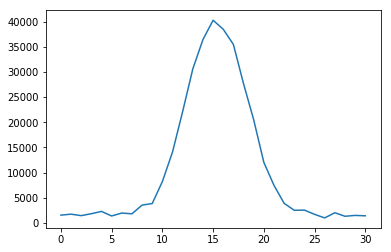

In [7]:
rm_metadata_azsweep = np.asfarray(azsweep[:, DATA_START:], float)
rm_bg_azsweep = remove_background(rm_metadata_azsweep, tsys)
avgbT_azsweep = np.mean(antennaT_to_brightnessT(rm_bg_azsweep), axis=1)

plt.plot(range(31), avgbT_azsweep)
plt.show()

In [8]:
# define diffraction model
import scipy.special
def circular_diffraction(theta, I, a):
    k = 29.7695032399
    return np.where(theta == 0, I, I * ( (2 * scipy.special.j1(k * a * np.sin(theta))) / (k * a * np.sin(theta)) )**2)
    

/home/evan/.env/jlab/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """
/home/evan/.env/jlab/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in double_scalars
  """


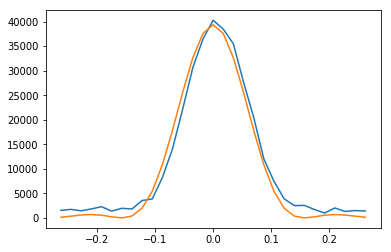

[  3.93634002e+04   8.27735545e-01]


In [9]:
x = np.array([i*2*3.14/360 for i in range(-15, 16, 1)])

popt, perr, chisq = utils.fit_model(x, avgbT_azsweep, 31*[5000], (30000, 1), circular_diffraction)
plt.plot(x, avgbT_azsweep)
plt.plot(x, [circular_diffraction(xi, *popt) for xi in x])
plt.show()

print(popt)